In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray

In [ ]:
def preprocess_image(image_path, k=1):
    """
    Carga y preprocesa una imagen desde la ruta especificada.
    La imagen se convierte a escala de grises y se redimensiona a un tamaño específico.
    El tamaño de la imagen resultante es (128k, 64k) donde k es un factor de escala.
    
    Args:
        k (int): Factor de escala para redimensionar la imagen. Por defecto es 1.

    Returns:
        numpy.ndarray: Imagen preprocesada en formato float32.
    """
    try:
        # Leer la imagen
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"No se pudo leer la imagen en la ruta: {image_path}")
        
        # Verificar que k sea válido
        if k < 1:
            raise ValueError("k debe ser mayor o igual a 1")

        # Convertir a escala de grises
        gray_image = rgb2gray(image)  # devuelve una imagen en float64 [0, 1]

        # Redimensionar la imagen al tamaño (128k, 64k)
        new_size = (64 * k, 128 * k)  # (ancho, alto)
        resized_image = cv2.resize(gray_image, new_size, interpolation=cv2.INTER_AREA) # Cambiar el orden a (alto, ancho)

        # Convertir a float32 si se desea trabajar en precisión simple
        return resized_image.astype(np.float32)
   
    except Exception as e:
        print(f"ERROR | {e}")
        return None

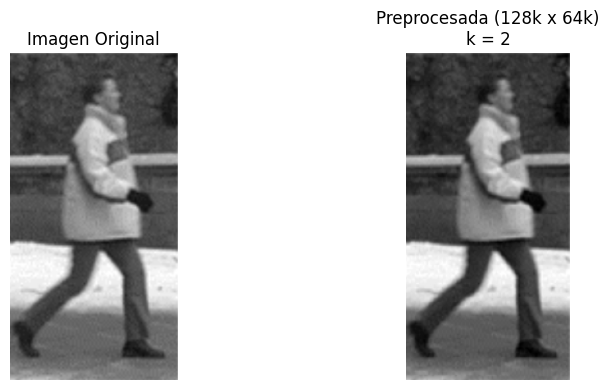

In [3]:
image = cv2.imread("Images/person.png")
k = 2  # Factor de escala
processed = preprocess_image("Images/person.png", k)


# Mostrar la imagen original y la preprocesada
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Imagen Original')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f'Preprocesada (128k x 64k)\nk = {k}')
plt.imshow(processed, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
print(f"Tamaño de la imagen preprocesada: {processed.shape}")

Tamaño de la imagen preprocesada: (256, 128)
Tamaño de la imagen original: (585, 300, 3)
